# IPC Section Classifier  
This notebook walks through:  
1. **Loading** the `(text, section)` dataset  
2. **Cleaning & preprocessing** the text  
3. **Exploratory Data Analysis** (label distribution, text lengths)  
4. **Training** a TF-IDF + Logistic Regression model (with hyperparameter tuning)  
5. **Evaluation** (accuracy, precision, recall, F1, confusion matrix)  
6. **Saving** the final pipeline  


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection  import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)


In [3]:
# Load your CSV
df = pd.read_csv("data/ipc_sections_dataset.csv")
df.tail()


,text,section
6627,1. Stephen's History of Criminal Law of Englan...,511
6628,s three stages—\n(1) intention to commit it;\n...,122
6629,territories of any power at peace with the\nGo...,126
6630,will of the party. An attempt is punishable ev...,511
6631,"2. Note Q, p 174. 3. Mrs. Sarah Mathew v The I...",1873


In [4]:
# Drop any "unknown" sections
df = df[df["section"] != "unknown"].copy()

# Simple text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)   # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()    # collapse whitespace
    return text

df["clean_text"] = df["text"].apply(clean_text)
df["clean_text"].str[:200].head()


0    the indian p enal code pb 36th ed ratanlal dhi...
1    the indian penal code act xlv of 1860 received...
2    the indian penal code chapter i introduction t...
3    1 it is not necessary and indeed not permissib...
4    india 4 except the state of jammu and kashmir ...
Name: clean_text, dtype: object

In [5]:
# Count how many examples per section
counts = df["section"].value_counts()

# Keep only sections with ≥2 examples
valid_secs = counts[counts >= 2].index
df = df[df["section"].isin(valid_secs)].copy()

# (Optional) If you want to lump all rare ones under "OTHER" instead:
df["section"] = df["section"].where(df["section"].isin(valid_secs), other="OTHER")


C:\Users\Chinmay Srivastava\AppData\Local\Temp\ipykernel_18016\1958384417.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


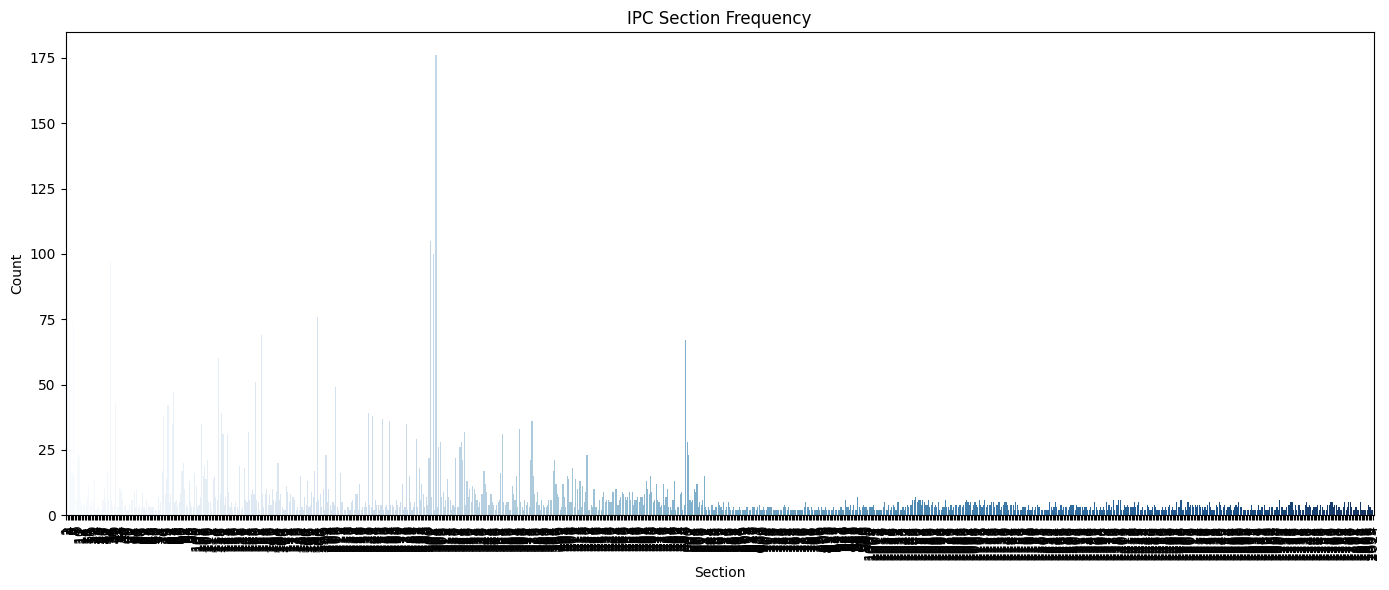

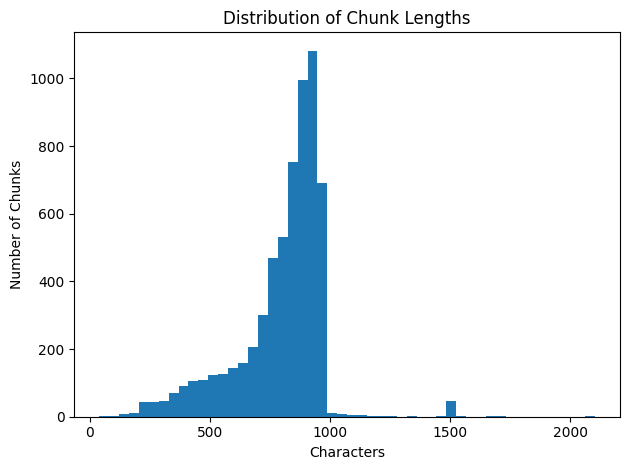

In [6]:
import seaborn as sns

label_counts = df["section"].value_counts()
plt.figure(figsize=(14, 6))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    palette="Blues"
)
plt.title("IPC Section Frequency")
plt.xlabel("Section")
plt.ylabel("Count")
# 4. Rotate x-labels and tighten layout
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


lengths = df["clean_text"].str.len()
plt.figure()
plt.hist(lengths, bins=50)
plt.title("Distribution of Chunk Lengths")
plt.xlabel("Characters")
plt.ylabel("Number of Chunks")
plt.tight_layout()
plt.show()


In [6]:
# Encode sections
le = LabelEncoder()
df['section_id'] = le.fit_transform(df['section'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['section_id'],
    test_size=0.15, stratify=df['section_id'], random_state=42
)

In [7]:
# Safe CV
min_count = pd.Series(y_train).value_counts().min()
n_splits = max(2, min(3, min_count))
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Pipeline with sparse solver & single‐job LR
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10_000,      # reduced to save RAM
        stop_words='english'
    )),
    ('clf', LogisticRegression(
        solver='saga',            # sparse‐friendly
        max_iter=2000,
        class_weight='balanced',
        n_jobs=1,
        verbose=1
    ))
])

param_grid = {
    'tfidf__max_features': [5_000, 10_000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1.0]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,            # parallelize across grid‐points, not within each fit
    verbose=1,
    error_score='raise'
)

grid.fit(X_train, y_train)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
convergence after 19 epochs took 67 seconds


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=10000,
                                                        ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=2000,
                                                           n_jobs=1,
                                                           solver='saga',
                                                           verbose=1))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1.0],
                         'tfidf__max_features': [5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_weighted', verbose=1)

In [8]:
print("Best parameters:", grid.best_params_)
print("Training F1 (weighted):", grid.best_score_)

Best parameters: {'clf__C': 1.0, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}
Training F1 (weighted): 0.26496986868512223


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=le.transform(le.classes_))

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report
)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# overall metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_test, y_pred, average="weighted", zero_division=0)


print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}\n")

# ---- fix for classification_report ----
# 1. select only the labels actually in y_test
labels = np.unique(y_test)

# 2. get their original names via LabelEncoder
raw_names = le.inverse_transform(labels)

# 3. cast every name to string so len() works
target_names = [str(name) for name in raw_names]

# 4. pass both to classification_report
print("Classification Report:\n")
print(
    classification_report(
        y_test, y_pred,
        labels=labels.tolist(),
        target_names=target_names,
        zero_division=0
    )
)


Accuracy: 0.3258
Precision (weighted): 0.3667
Recall (weighted): 0.3258
F1 Score (weighted): 0.3054

Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       1.00      0.64      0.78        11
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          

In [14]:
# 11. Save vectorizer, classifier (and label encoder) separately
import os
import pickle
import json

# ensure the target directory exists
os.makedirs("models/Predict_Section", exist_ok=True)

# save the TF-IDF vectorizer
with open("models/Predict_Section/Law_vectorizer.pkl", "wb") as f:
    pickle.dump(best_model.named_steps["tfidf"], f)

# save the logistic regression classifier
with open("models/Predict_Section/Law_classifier.pkl", "wb") as f:
    pickle.dump(best_model.named_steps["clf"], f)

# (optional) save the LabelEncoder as well
with open("models/Predict_Section/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)
    

ipc_metrics = {
    "accuracy": f"{acc:.4f}",
    "precision": f"{prec:.4f}",
    "recall": f"{rec:.4f}",
    "f1_score": f"{f1:.4f}",
    "classification_report": classification_report(y_test, y_pred, output_dict=True),
    "confusion_matrix": cm.tolist()
}
with open("models/Predict_Section/ipc_metrics.json", "w") as f:
    json.dump(ipc_metrics, f, indent=2)


print("Saved Law_vectorizer.pkl, Law_classifier.pkl (and label_encoder.pkl) under models/law/")


c:\Users\Chinmay Srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chinmay Srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Chinmay Srivastava\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this be

Saved Law_vectorizer.pkl, Law_classifier.pkl (and label_encoder.pkl) under models/law/
